In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
from pmdarima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
covid_19= files.upload()

Saving banladesh.csv to banladesh.csv


In [ ]:
import io
covid=pd.read_csv(io.BytesIO(covid_19['banladesh.csv']))
covid.head()

,ObservationDate,Confirmed
0,3/8/2020,3
1,3/9/2020,3
2,3/10/2020,3
3,3/11/2020,3
4,3/12/2020,3


In [ ]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (834, 2)
Checking for null values:
 ObservationDate    0
Confirmed          0
dtype: int64
Checking Data-type of each column:
 ObservationDate    object
Confirmed           int64
dtype: object


In [ ]:
#Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

In [ ]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

## Datewise analysis

In [ ]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [ ]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  223
Total number of Confirmed Cases around the World:  24996456.0
Total number of Recovered Cases around the World:  16409757.0
Total number of Deaths Cases around the World:  842499.0
Total number of Active Cases around the World:  7744200.0
Total number of Closed Cases around the World:  17252256.0
Approximate number of Confirmed Cases per Day around the World:  113106.0
Approximate number of Recovered Cases per Day around the World:  74252.0
Approximate number of Death Cases per Day around the World:  3812.0
Approximate number of Confirmed Cases per hour around the World:  4713.0
Approximate number of Recovered Cases per hour around the World:  3094.0
Approximate number of Death Cases per hour around the World:  159.0
Number of Confirmed Cases in last 24 hours:  262008.0
Number of Recovered Cases in last 24 hours:  211592.0
Number of Death Cases in last 24 hours:  5375.0


In [ ]:
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [ ]:
fig=px.bar(x=datewise.index,y=datewise["Recovered"]+datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Closed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

In [ ]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

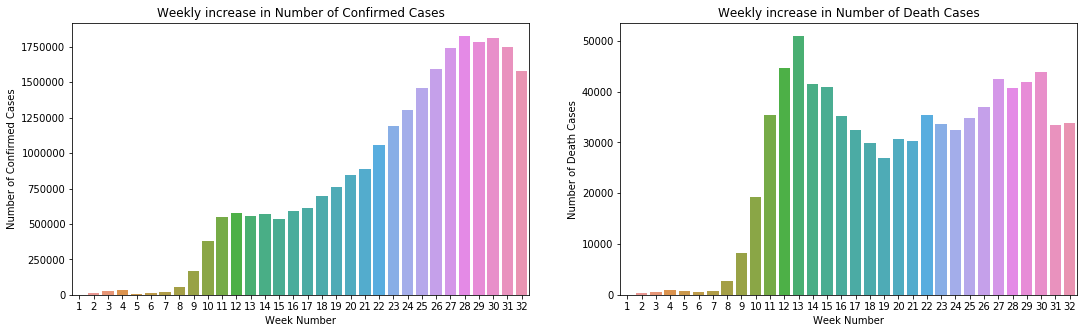

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

#### Growth rate of Confirmed, Recovered and Death Cases

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#### Moratality and Recovery Rate analysis around the World

In [ ]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Recovered"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Recovered"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Recovered"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 4.63410412483686
Median Mortality Rate 4.4083056727246195
Average Recovery Rate 39.16083883932323
Median Recovery Rate 42.09012917192399


#### Mortality rate = (Number of Death Cases / Number of Confirmed Cases) x 100
#### Recovery Rate= (Number of Recoverd Cases / Number of Confirmed Cases) x 100
#### Mortality rate is showing a considerable for a pretty long time, which is positive sign
#### Recovery Rate has started to pick up again which is a good sign, another supportive reason to why number of Closed Cases are increasing

In [ ]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  113104.0
Average increase in number of Recovered Cases every day:  74252.0
Average increase in number of Deaths Cases every day:  3812.0


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="7 Days Rolling Mean of Daily Increase of Confirmed, Recovered and Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## Countrywise Analysis

In [ ]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [ ]:
country_last_24_confirmed=[]
country_last_24_recovered=[]
country_last_24_deaths=[]
for country in countrywise.index:
    country_last_24_confirmed.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Confirmed"])
    country_last_24_recovered.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Recovered"])
    country_last_24_deaths.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Deaths"])

In [ ]:
Last_24_Hours_country=pd.DataFrame(list(zip(countrywise.index,country_last_24_confirmed,country_last_24_recovered,country_last_24_deaths)),
                                   columns=["Country Name","Last 24 Hours Confirmed","Last 24 Hours Recovered","Last 24 Hours Deaths"])

Text(0.5, 1.0, 'Top 15 Countries with Highest Number of Death Cases in Last 24 Hours')

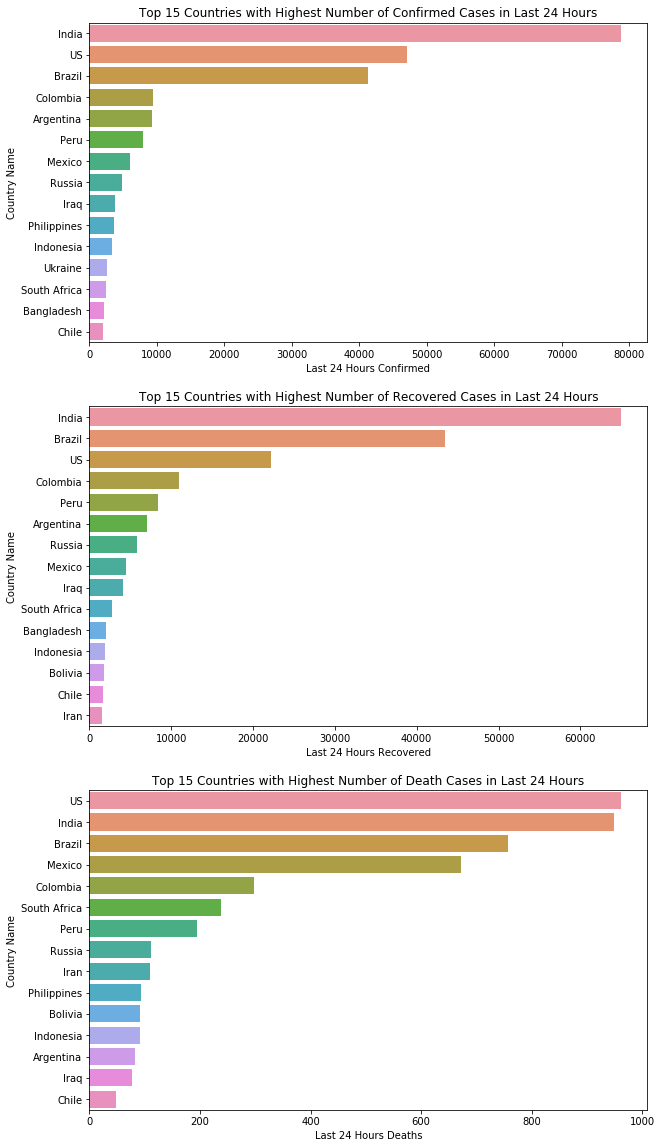

In [ ]:
Top_15_Confirmed_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Confirmed"],ascending=False).head(15)
Top_15_Recoverd_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Recovered"],ascending=False).head(15)
Top_15_Deaths_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Deaths"],ascending=False).head(15)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,20))
sns.barplot(x=Top_15_Confirmed_24hr["Last 24 Hours Confirmed"],y=Top_15_Confirmed_24hr["Country Name"],ax=ax1)
ax1.set_title("Top 15 Countries with Highest Number of Confirmed Cases in Last 24 Hours")
sns.barplot(x=Top_15_Recoverd_24hr["Last 24 Hours Recovered"],y=Top_15_Recoverd_24hr["Country Name"],ax=ax2)
ax2.set_title("Top 15 Countries with Highest Number of Recovered Cases in Last 24 Hours")
sns.barplot(x=Top_15_Deaths_24hr["Last 24 Hours Deaths"],y=Top_15_Deaths_24hr["Country Name"],ax=ax3)
ax3.set_title("Top 15 Countries with Highest Number of Death Cases in Last 24 Hours")

In [ ]:
Last_24_Hours_country["Proportion of Confirmed"]=(Last_24_Hours_country["Last 24 Hours Confirmed"]/(datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Recovered"]=(Last_24_Hours_country["Last 24 Hours Recovered"]/(datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Deaths"]=(Last_24_Hours_country["Last 24 Hours Deaths"]/(datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2]))*100

In [ ]:
Last_24_Hours_country[["Country Name","Proportion of Confirmed","Proportion of Recovered","Proportion of Deaths"]].sort_values(["Proportion of Confirmed"],ascending=False).style.background_gradient(cmap="Reds")

,Country Name,Proportion of Confirmed,Proportion of Recovered,Proportion of Deaths
2,India,30.0605,30.6888,17.6372
0,US,17.9968,10.5141,17.8791
1,Brazil,15.782,20.5121,14.1023
6,Colombia,3.58462,5.17694,5.52558
10,Argentina,3.52279,3.33425,1.52558
4,Peru,3.0396,3.94864,3.6093
7,Mexico,2.28008,2.13288,12.5209
3,Russia,1.84842,2.77279,2.06512
20,Iraq,1.46331,1.95943,1.43256
21,Philippines,1.36904,0.296325,1.74884


Text(0.5, 1.0, 'Top 15 countries as per Number of Death Cases')

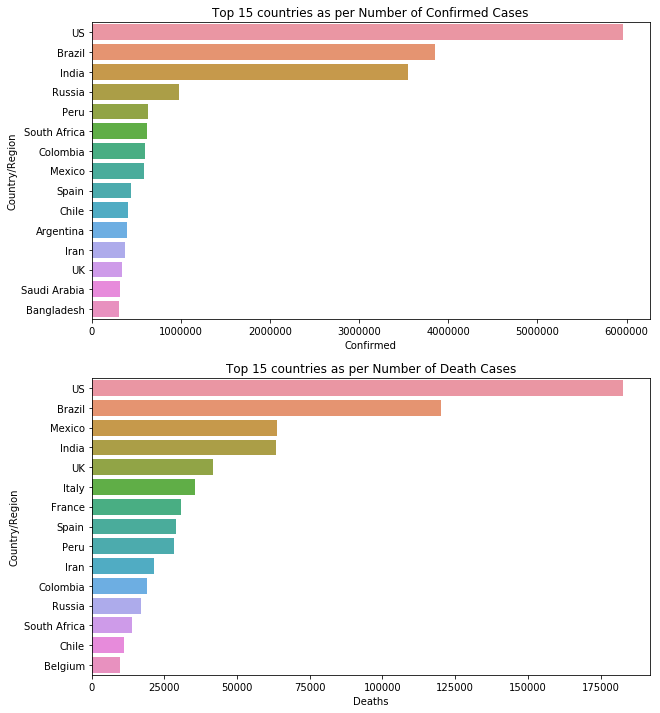

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,12))
top_15_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 countries as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 countries as per Number of Death Cases")

## Clustering of Countries

In [ ]:
X=countrywise[["Mortality","Recovery"]]
#Standard Scaling since K-Means Clustering is a distance based alogrithm
X=std.fit_transform(X)

In [ ]:
wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Elbow Method')

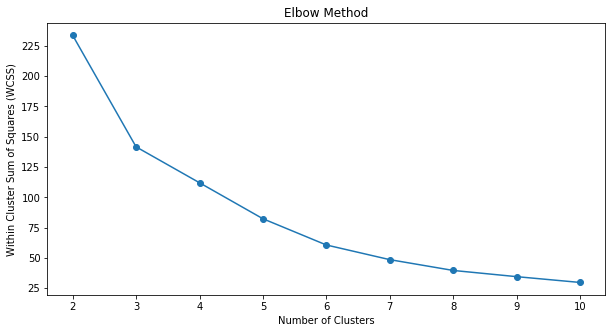

In [ ]:
x=np.arange(2,11)
plt.figure(figsize=(10,5))
plt.plot(x,wcss,marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method")

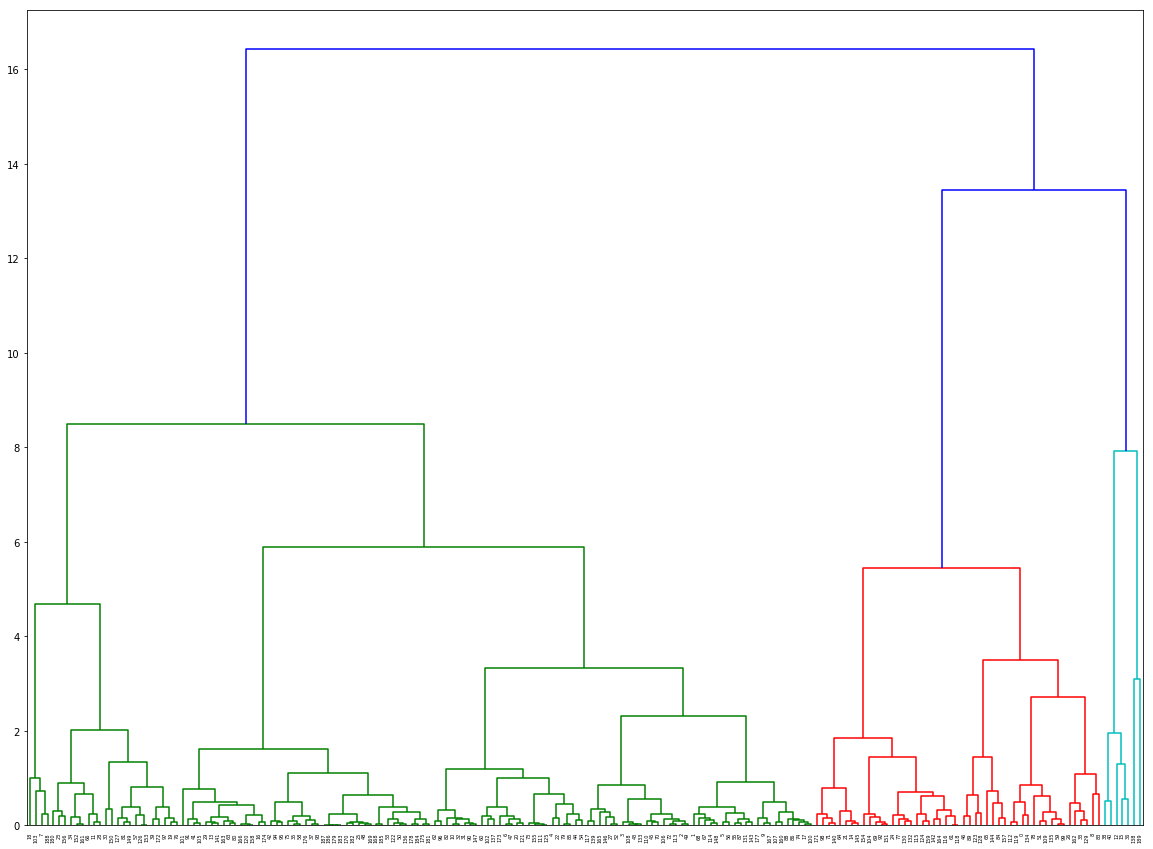

In [ ]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(20,15))
dendogram=sch.dendrogram(sch.linkage(X, method  = "ward"))

All methods namely Elbow Method and Hierarchical Clustering shows **K=3** will correct number of clusters.

In [ ]:
clf_final=KMeans(n_clusters=3,init='k-means++',random_state=6)
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=6, tol=0.0001, verbose=0)

In [ ]:
countrywise["Clusters"]=clf_final.predict(X)

#### Summary of Clusters

In [ ]:
cluster_summary=pd.concat([countrywise[countrywise["Clusters"]==1].head(15),countrywise[countrywise["Clusters"]==2].head(15),countrywise[countrywise["Clusters"]==0].head(15)])
cluster_summary.style.background_gradient(cmap='Reds').format("{:.2f}")

,Confirmed,Recovered,Deaths,Mortality,Recovery,Active Cases,Outcome Cases,Confirm Cases/Day,Survival Probability,Clusters
Country/Region,,,,,,,,,,
Brazil,3846153.00,3202185.00,120262.00,3.13,83.26,523706.00,3322447.00,20567.66,96.87,1.00
India,3542733.00,2713933.00,63498.00,1.79,76.61,765302.00,2777431.00,16632.55,98.21,1.00
Russia,982573.00,802365.00,16977.00,1.73,81.66,163231.00,819342.00,4634.78,98.27,1.00
Peru,629961.00,438017.00,28471.00,4.52,69.53,163473.00,466488.00,3559.10,95.48,1.00
South Africa,622551.00,536694.00,13981.00,2.25,86.21,71876.00,550675.00,3497.48,97.75,1.00
Colombia,599884.00,440562.00,19063.00,3.18,73.44,140259.00,459625.00,3370.13,96.82,1.00
Chile,408009.00,381183.00,11181.00,2.74,93.43,15645.00,392364.00,2266.72,97.26,1.00
Argentina,401239.00,287220.00,8353.00,2.08,71.58,105666.00,295573.00,2229.11,97.92,1.00
Iran,371816.00,319847.00,21359.00,5.74,86.02,30610.00,341206.00,1926.51,94.26,1.00


In [ ]:
print("Avergae Mortality Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Recovery"].mean())

Avergae Mortality Rate of Cluster 0:  13.887372332715879
Avergae Recovery Rate of Cluster 0:  41.53445614899263
Avergae Mortality Rate of Cluster 1:  2.2463194361559777
Avergae Recovery Rate of Cluster 1:  83.75183966895968
Avergae Mortality Rate of Cluster 2:  2.3649469755029386
Avergae Recovery Rate of Cluster 2:  39.4954479457303


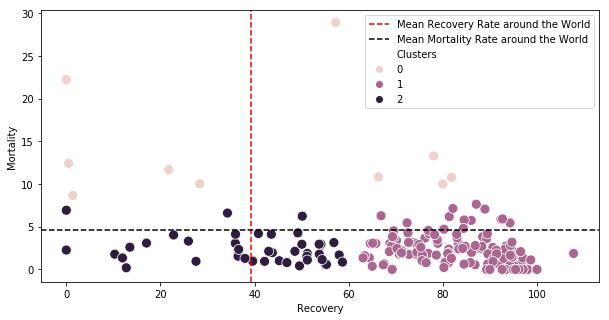

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=countrywise["Recovery"],y=countrywise["Mortality"],hue=countrywise["Clusters"],s=100)
plt.axvline(((datewise["Recovered"]/datewise["Confirmed"])*100).mean(),
            color='red',linestyle="--",label="Mean Recovery Rate around the World")
plt.axhline(((datewise["Deaths"]/datewise["Confirmed"])*100).mean(),
            color='black',linestyle="--",label="Mean Mortality Rate around the World")
plt.legend()

In [ ]:
print("Few Countries belonging to Cluster 0: ",list(countrywise[countrywise["Clusters"]==0].head(10).index))
print("Few Countries belonging to Cluster 1: ",list(countrywise[countrywise["Clusters"]==1].head(10).index))
print("Few Countries belonging to Cluster 2: ",list(countrywise[countrywise["Clusters"]==2].head(10).index))

Few Countries belonging to Cluster 0:  ['Mexico', 'UK', 'France', 'Italy', 'Belgium', 'Netherlands', 'Hungary', 'Yemen', 'Western Sahara', 'MS Zaandam']
Few Countries belonging to Cluster 1:  ['Brazil', 'India', 'Russia', 'Peru', 'South Africa', 'Colombia', 'Chile', 'Argentina', 'Iran', 'Saudi Arabia']
Few Countries belonging to Cluster 2:  ['US', 'Spain', 'Ukraine', 'Bolivia', 'Romania', 'Sweden', 'Honduras', 'Ethiopia', 'Costa Rica', 'Nepal']


Cluster 2 is a set of countries which have really **High Mortality Rate** and consdierably **Good Recovery Rate**. Basically few countries among these clusters have seen already the worst of this pandemic but are now recovering with healty Recovery Rate.

Cluster 0 is set of countries which have **Low Mortality Rate** and really **High Recovery Rate**. These are the set of countries who has been able to control the COVID-19 by following pandemic controlling practices rigorously.

Cluster 1 is set of countries which have **Low Mortality Rate** and really **Low Recovery Rate**. These countries need to pace up their Revovery Rate to get out it, Some thses countries have really high number of Infected Cases but Low Mortality is positive sign out of it.

### Comparison of China, Italy, US, Spain, Brazil and Rest of the World

In [ ]:
china_data=covid[covid["Country/Region"]=="Mainland China"]
Italy_data=covid[covid["Country/Region"]=="Italy"]
US_data=covid[covid["Country/Region"]=="US"]
spain_data=covid[covid["Country/Region"]=="Spain"]
brazil_data=covid[covid["Country/Region"]=="Brazil"]
rest_of_world=covid[(covid["Country/Region"]!="Mainland China")&(covid["Country/Region"]!="Italy")&(covid["Country/Region"]!="US")&(covid["Country/Region"]!="Spain")&(covid["Country/Region"]!="Brazil")]

datewise_china=china_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Italy=Italy_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_US=US_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Spain=spain_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Brazil=brazil_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_restofworld=rest_of_world.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Confirmed"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Confirmed"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Confirmed"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Confirmed"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Confirmed"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Confirmed"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Confirmed Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Recovered"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Recovered"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Recovered"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Recovered"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Recovered"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Recovered"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Recovered Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Deaths"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Deaths"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Deaths"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Deaths"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Deaths"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Deaths"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Death Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
datewise_china["Mortality"]=(datewise_china["Deaths"]/datewise_china["Confirmed"])*100
datewise_Italy["Mortality"]=(datewise_Italy["Deaths"]/datewise_Italy["Confirmed"])*100
datewise_US["Mortality"]=(datewise_US["Deaths"]/datewise_US["Confirmed"])*100
datewise_Spain["Mortality"]=(datewise_Spain["Deaths"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Mortality"]=(datewise_Brazil["Deaths"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Mortality"]=(datewise_restofworld["Deaths"]/datewise_restofworld["Confirmed"])*100

datewise_china["Recovery"]=(datewise_china["Recovered"]/datewise_china["Confirmed"])*100
datewise_Italy["Recovery"]=(datewise_Italy["Recovered"]/datewise_Italy["Confirmed"])*100
datewise_US["Recovery"]=(datewise_US["Recovered"]/datewise_US["Confirmed"])*100
datewise_Spain["Recovery"]=(datewise_Spain["Recovered"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Recovery"]=(datewise_Brazil["Recovered"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Recovery"]=(datewise_restofworld["Recovered"]/datewise_restofworld["Confirmed"])*100

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Mortality"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Mortality"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Mortality"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Mortality"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Mortality"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Mortality"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Mortality Rate comparison plot",
                  xaxis_title="Date",yaxis_title="Mortality Rate",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Recovery"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Recovery"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Recovery"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Recovery"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Recovery"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Recovery"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Recovery Rate comparison plot",
                  xaxis_title="Date",yaxis_title="Recovery Rate",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## Prediction using Machine Learning Models

#### Linear Regression Model for Confirm Cases Prediction

In [ ]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [ ]:
lin_reg=LinearRegression(normalize=True)

In [ ]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(normalize=True)

In [ ]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  102642.18199732323


In [ ]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

#### The Linear Regression Model is absolutely falling aprat. As it is clearly visible that the trend of Confirmed Cases in absolutely not Linear.

#### Polynomial Regression for Prediction of Confirmed Cases

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
poly = PolynomialFeatures(degree = 8)

In [ ]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [ ]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(normalize=True)

In [ ]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  736403.9823205664


In [ ]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [ ]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

#### Support Vector Machine ModelRegressor for Prediction of Confirmed Cases

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
#Intializing SVR Model
svm=SVR(C=10,degree=6,kernel='rbf',epsilon=0.05)

In [ ]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=10, degree=6, epsilon=0.05)

In [ ]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  1289182.102760344


In [ ]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

#### Support Vector Machine model isn't providing great results now, the predictions are either overshooting or really lower than what's expected.

In [ ]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2022-06-20,2111179.934039,422612.640831,664283.959696
1,2022-06-21,2113992.358577,356910.425024,664274.808218
2,2022-06-22,2116804.783116,289216.815668,664265.664438
3,2022-06-23,2119617.207654,219489.038141,664256.528819
4,2022-06-24,2122429.632192,147683.646683,664247.401819


Predictions of Linear Regression are nowhere close to actual values.

## Time Series Forecasting

#### Holt's Linear Model

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)

In [ ]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  904.2487174408315


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2022-06-20,2111179.934039,422612.640831,4006467.992822,1953288.654424
1,2022-06-21,2113992.358577,356910.425024,4031623.990194,1953300.208809
2,2022-06-22,2116804.783116,289216.815668,4056931.074129,1953311.763193
3,2022-06-23,2119617.207654,219489.038141,4082389.969697,1953323.317578
4,2022-06-24,2122429.632192,147683.646683,4108001.404574,1953334.871963


#### Holt's Winter Model for Daily Time Series

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=14,trend='add', seasonal='mul').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  3509.6586350727384


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
holt_winter_new_prediction=[]
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2022-06-20,2111179.934039,422612.640831,4006467.992822,1953288.654424,1951239.258299
1,2022-06-21,2113992.358577,356910.425024,4031623.990194,1953300.208809,1951777.102651
2,2022-06-22,2116804.783116,289216.815668,4056931.074129,1953311.763193,1952008.328743
3,2022-06-23,2119617.207654,219489.038141,4082389.969697,1953323.317578,1951940.837052
4,2022-06-24,2122429.632192,147683.646683,4108001.404574,1953334.871963,1951381.886477


In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

### AR Model (using AUTO ARIMA)

In [ ]:
model_ar= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=12633.521, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=12634.994, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=12627.968, Time=0.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=12624.623, Time=0.17 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=12623.730, Time=0.20 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0] intercept
Total fit time: 0.627 seconds


ARIMA(order=(4, 2, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  690.4070882844562


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
AR_model_new_prediction=[]
for i in range(1,18):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2022-06-20,2111179.934039,422612.640831,4006467.992822,1953288.654424,1951239.258299,1953727.338577
1,2022-06-21,2113992.358577,356910.425024,4031623.990194,1953300.208809,1951777.102651,1953749.447014
2,2022-06-22,2116804.783116,289216.815668,4056931.074129,1953311.763193,1952008.328743,1953771.582075
3,2022-06-23,2119617.207654,219489.038141,4082389.969697,1953323.317578,1951940.837052,1953793.743762
4,2022-06-24,2122429.632192,147683.646683,4108001.404574,1953334.871963,1951381.886477,1953815.932073


### MA Model (using AUTO ARIMA)

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
model_ma= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=12633.521, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=12634.868, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=12627.505, Time=0.20 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0] intercept
Total fit time: 0.336 seconds


ARIMA(order=(0, 2, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))

Root Mean Square Error for MA Model:  659.3927614399765


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
MA_model_new_prediction=[]
for i in range(1,18):
    MA_model_new_prediction.append(model_ma.predict(len(valid)+i)[-1])
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2022-06-20,2111179.934039,422612.640831,4006467.992822,1953288.654424,1951239.258299,1953727.338577,1953796.419312
1,2022-06-21,2113992.358577,356910.425024,4031623.990194,1953300.208809,1951777.102651,1953749.447014,1953820.235656
2,2022-06-22,2116804.783116,289216.815668,4056931.074129,1953311.763193,1952008.328743,1953771.582075,1953844.082044
3,2022-06-23,2119617.207654,219489.038141,4082389.969697,1953323.317578,1951940.837052,1953793.743762,1953867.958477
4,2022-06-24,2122429.632192,147683.646683,4108001.404574,1953334.871963,1951381.886477,1953815.932073,1953891.864953


### ARIMA Model (using AUTOARIMA)

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=12633.521, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=12634.868, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=12627.505, Time=0.18 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=12622.147, Time=0.21 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=12634.994, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=12634.299, Time=0.27 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=12624.837, Time=0.42 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=12621.254, Time=0.77 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=12627.968, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=12622.641, Time=0.40 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=12550.678, Time=1.35 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=12564.004, Time=2.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=12624.623, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=12622.793, Time=0.47 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=12542.736, Time=2.35

ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  713.5672654041147


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2022-06-20,2111179.934039,422612.640831,4006467.992822,1953288.654424,1951239.258299,1953727.338577,1953796.419312,1953680.945449
1,2022-06-21,2113992.358577,356910.425024,4031623.990194,1953300.208809,1951777.102651,1953749.447014,1953820.235656,1953702.621058
2,2022-06-22,2116804.783116,289216.815668,4056931.074129,1953311.763193,1952008.328743,1953771.582075,1953844.082044,1953723.303729
3,2022-06-23,2119617.207654,219489.038141,4082389.969697,1953323.317578,1951940.837052,1953793.743762,1953867.958477,1953743.520721
4,2022-06-24,2122429.632192,147683.646683,4108001.404574,1953334.871963,1951381.886477,1953815.932073,1953891.864953,1953764.155336


### SARIMA Model (using AUTO ARIMA)

In [ ]:
model_sarima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore',
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=12326.491, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=12631.523, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=12377.884, Time=0.27 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=12483.412, Time=0.40 sec
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=12481.459, Time=0.23 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=12375.919, Time=0.07 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=12324.160, Time=0.61 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=12322.526, Time=0.14 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=12322.928, Time=0.53 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=12322.911, Time=0.52 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=inf, Time=2.95 sec
 ARIMA(0,2,0)(2,0,0)[7] intercept   : AIC=12324.404, Time=1.05 sec

Best model:  ARIMA(0,2,0)(2,0,0)[7]          
Total fit time: 7.080 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(2, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [ ]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  760.0981908405582


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
SARIMA_model_new_prediction=[]
for i in range(1,18):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2022-06-20,2111179.934039,422612.640831,4006467.992822,1953288.654424,1951239.258299,1953727.338577,1953796.419312,1953680.945449,1953586.830246
1,2022-06-21,2113992.358577,356910.425024,4031623.990194,1953300.208809,1951777.102651,1953749.447014,1953820.235656,1953702.621058,1953605.834620
2,2022-06-22,2116804.783116,289216.815668,4056931.074129,1953311.763193,1952008.328743,1953771.582075,1953844.082044,1953723.303729,1953625.193045
3,2022-06-23,2119617.207654,219489.038141,4082389.969697,1953323.317578,1951940.837052,1953793.743762,1953867.958477,1953743.520721,1953643.956654
4,2022-06-24,2122429.632192,147683.646683,4108001.404574,1953334.871963,1951381.886477,1953815.932073,1953891.864953,1953764.155336,1953664.235622


### Facebook's Prophet Model for forecasting

In [ ]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])

In [ ]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [ ]:
confirmed_forecast=prophet_c.predict(forecast_c)
#print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  5328.450000349874


Figure(720x432)


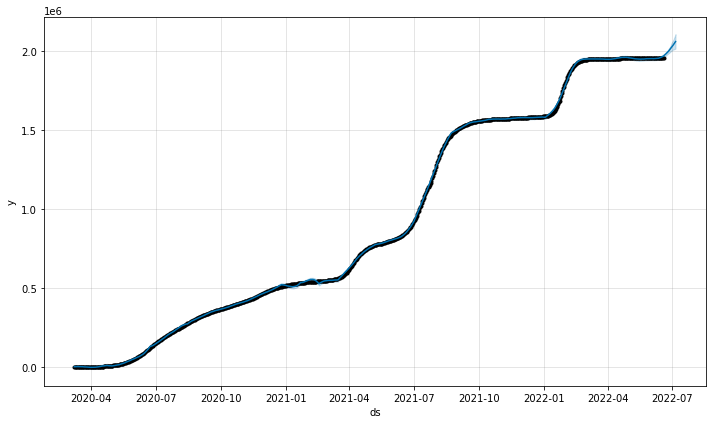

In [ ]:
print(prophet_c.plot(confirmed_forecast))

Figure(648x648)


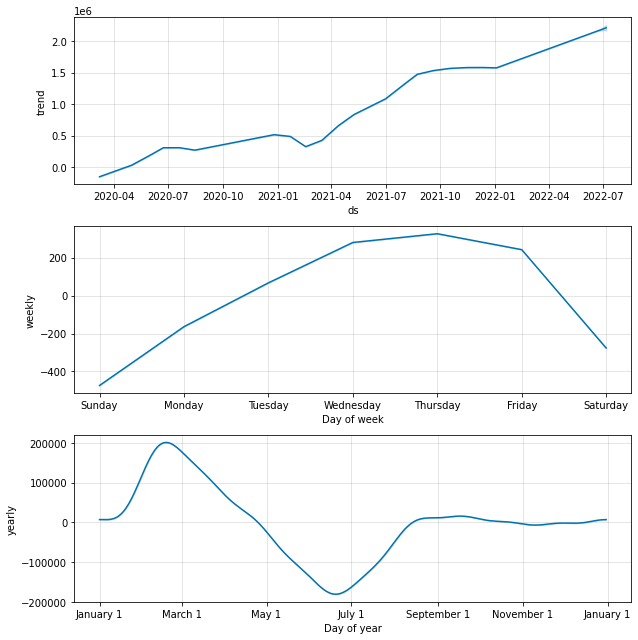

In [ ]:
print(prophet_c.plot_components(confirmed_forecast))

#### Summarization of Forecasts using different Models

In [ ]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
6,Moving Average Model (MA),659.392761
5,Auto Regressive Model (AR),690.407088
7,ARIMA Model,713.567265
8,SARIMA Model,760.098191
3,Holt's Linear,904.248717
4,Holt's Winter Model,3509.658635
9,Facebook's Prophet Model,5328.450000
0,Linear Regression,102642.181997
1,Polynomial Regression,736403.982321
2,Support Vector Machine Regressor,1579764.159941


In [ ]:
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(17))
model_predictions["Prophet's Upper Bound"]=list(confirmed_forecast["yhat_upper"].tail(17))
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound
0,2022-06-20,2111179.934039,422612.640831,4006467.992822,1953288.654424,1951239.258299,1953727.338577,1953796.419312,1953680.945449,1953586.830246,1971758.492739,1982641.115467
1,2022-06-21,2113992.358577,356910.425024,4031623.990194,1953300.208809,1951777.102651,1953749.447014,1953820.235656,1953702.621058,1953605.834620,1975629.439266,1986326.325513
2,2022-06-22,2116804.783116,289216.815668,4056931.074129,1953311.763193,1952008.328743,1953771.582075,1953844.082044,1953723.303729,1953625.193045,1979810.394976,1991135.047063
3,2022-06-23,2119617.207654,219489.038141,4082389.969697,1953323.317578,1951940.837052,1953793.743762,1953867.958477,1953743.520721,1953643.956654,1984142.651043,1995493.705022
4,2022-06-24,2122429.632192,147683.646683,4108001.404574,1953334.871963,1951381.886477,1953815.932073,1953891.864953,1953764.155336,1953664.235622,1988648.748278,2000698.437789


### Time Series Forecasting for Death Cases

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
model_arima_deaths=auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=5,max_q=5,suppress_warnings=True,stepwise=False,seasonal=False)
model_arima_deaths.fit(model_train["Deaths"])

Fit ARIMA: order=(0, 2, 0); AIC=3541.341, BIC=3548.007, Fit time=0.005 seconds
Fit ARIMA: order=(0, 2, 1); AIC=3539.859, BIC=3549.857, Fit time=0.025 seconds
Fit ARIMA: order=(0, 2, 2); AIC=3524.869, BIC=3538.200, Fit time=0.166 seconds
Fit ARIMA: order=(0, 2, 3); AIC=3505.636, BIC=3522.299, Fit time=0.103 seconds
Fit ARIMA: order=(0, 2, 4); AIC=3494.794, BIC=3514.790, Fit time=0.337 seconds
Fit ARIMA: order=(0, 2, 5); AIC=3488.380, BIC=3511.709, Fit time=0.451 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3540.154, BIC=3550.152, Fit time=0.036 seconds
Fit ARIMA: order=(1, 2, 1); AIC=3519.411, BIC=3532.742, Fit time=0.142 seconds
Fit ARIMA: order=(1, 2, 2); AIC=3519.813, BIC=3536.477, Fit time=0.273 seconds
Fit ARIMA: order=(1, 2, 3); AIC=3504.940, BIC=3524.936, Fit time=0.319 seconds
Fit ARIMA: order=(1, 2, 4); AIC=3480.627, BIC=3503.956, Fit time=0.495 seconds
Fit ARIMA: order=(1, 2, 5); AIC=3482.536, BIC=3509.198, Fit time=0.822 seconds
Fit ARIMA: order=(2, 2, 0); AIC=3542.138, BIC=3555.4

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 2, 5),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=True, trend='c')

In [ ]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [ ]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],predictions_deaths)))

Root Mean Square Error:  9189.544807471926


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
ARIMA_model_death_forecast=[]
for i in range(1,18):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [ ]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2020-08-30,831241.399372
1,2020-08-31,833188.648041
2,2020-09-01,836891.240314
3,2020-09-02,842811.827947
4,2020-09-03,849788.807149
